In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4", temperature=0) 


In [2]:
url_input = input('Enter URLs')

In [3]:
url_input

'https://herjustice.org/'

In [4]:
'https://herjustice.org/'

'https://herjustice.org/'

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str
    analysts: List[Analyst] # Analyst asking questions
    human_analyst_feedback: str # Human feedback

In [6]:
# def determine_relevant_perspectives(state: AuditGraphState):
#     #Analyzes website to determine relevant stakeholder perspectives.
    
#     system_message = f"""Analyze the website {state['url']} to determine which stakeholder perspectives are relevant.
#     Consider:
#     1. Does the organization seek volunteers?
#     2. Do they accept donations?
#     3. Do they work with foundations?
#     4. Do they have beneficiaries?
#     5. Do they seek partnerships?
    
#     Return only relevant perspectives with justification."""

#     url_tavily_search = initialize_search(state['url'])

#     search_docs = url_tavily_search.invoke(f"site:{state['url']} about mission programs")
#     context = "\n".join([doc['content'] for doc in search_docs])
    
#     analysis = structured_llm.invoke([
#         SystemMessage(content=system_message),
#         HumanMessage(content=f"Based on this content:\n\n{context}")
#     ])
    
#     return {"relevant_perspectives": analysis.perspectives}

Each persona should analyze the NPO’s online presence and marketing materials to reveal how a specific audience views the organization. 
Create the following personas, each with a specialized perspective and set of recommendations tailored to enhance the NPO’s appeal to their respective audience.
provide a targeted analysis and actionable recommendations based on his unique perspective, ensuring that all insights align with the NPO’s current strategic needs and objectives."""    


In [7]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions = """You are tasked with creating a set of marketing analyst personas for an NPO.
Follow these instructions carefully:

1. First, review Non Profit Organizations (NPO's) to provide comprehensive audit of their online presence on their website.

2. Examine any insights into which different key players are there in the nonprofit sector—such as Volunteers, Foundations, Donors and others.

2. Assign one analyst persona to each key player where each persona represents a unique perspective from the nonprofit sector."""

# Focus each persona’s insights on areas relevant to the NPO’s current goals and omit those that are not applicable. 
# For example, if the NPO is not recruiting volunteers, the Volunteer marketing Analyst persona should not be included. 
 

def create_analysts(state: GenerateAnalystsState):
    
    human_analyst_feedback=state.get('human_analyst_feedback', '')
    structured_llm = llm.with_structured_output(Perspectives)
    system_message = analyst_instructions.format(human_analyst_feedback=human_analyst_feedback)
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    pass

def should_continue(state: GenerateAnalystsState):
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    return END

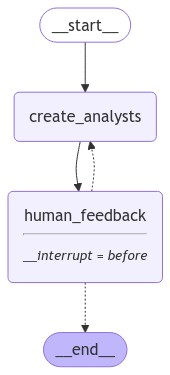

In [8]:
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:

# Input
# max_analysts = 3 
topic = 'https://herjustice.org/'
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interru|ption
for event in graph.stream({"topic":topic,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  


Name: Sarah Thompson
Affiliation: Volunteers
Role: Volunteer Engagement Analyst
Description: Sarah is responsible for analyzing the engagement and satisfaction of volunteers. She uses data to understand volunteer behavior, motivations, and needs. She also identifies opportunities to improve volunteer recruitment and retention strategies.
--------------------------------------------------
Name: James Wilson
Affiliation: Foundations
Role: Grant Analyst
Description: James specializes in analyzing grant data. He evaluates the effectiveness of grant programs, identifies trends in funding, and provides insights to help foundations make strategic decisions about where to allocate resources.
--------------------------------------------------
Name: Emily Davis
Affiliation: Donors
Role: Donor Relations Analyst
Description: Emily focuses on analyzing donor data. She tracks donor behavior and trends, identifies potential major donors, and provides insights to improve donor relations and fundraisin

In [10]:
# Get state and look at next node
state = graph.get_state(thread)
state.next


('human_feedback',)

In [11]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone to be Beneficiary analyst to add an Beneficiary perspective about NPO"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa5a18-8840-6951-8002-74fb9044a30f'}}

In [12]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Sarah Thompson
Affiliation: Volunteers
Role: Volunteer Engagement Analyst
Description: Sarah is responsible for analyzing the engagement and satisfaction of volunteers. She uses data to understand volunteer behavior, motivations, and needs. She also identifies opportunities to improve volunteer recruitment and retention strategies.
--------------------------------------------------
Name: James Wilson
Affiliation: Foundations
Role: Grant Analyst
Description: James specializes in analyzing grant data. He evaluates the effectiveness of grant programs, identifies trends in funding, and provides insights to help foundations make strategic decisions about where to allocate resources.
--------------------------------------------------
Name: Emily Davis
Affiliation: Donors
Role: Donor Relations Analyst
Description: Emily focuses on analyzing donor data. She tracks donor behavior and trends, identifies potential major donors, and provides insights to improve donor relations and fundraisin

In [13]:
# If we are satisfied, then supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa5a19-3bb3-65da-8004-ced971f256ba'}}

In [14]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [15]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [16]:
analysts

[Analyst(affiliation='Volunteers', name='Sarah Thompson', role='Volunteer Engagement Analyst', description='Sarah is responsible for analyzing the engagement and satisfaction of volunteers. She uses data to understand volunteer behavior, motivations, and needs. She also identifies opportunities to improve volunteer recruitment, retention, and engagement strategies.'),
 Analyst(affiliation='Foundations', name='James Wilson', role='Grant Analyst', description="James is responsible for analyzing the effectiveness of grant programs. He uses data to understand the impact of grants on the organization's mission and goals. He also identifies opportunities to improve grant application and management processes."),
 Analyst(affiliation='Donors', name='Emily Davis', role='Donor Relations Analyst', description='Emily is responsible for analyzing donor behavior and trends. She uses data to understand donor motivations and preferences. She also identifies opportunities to improve donor acquisition, 

In [17]:
final_state.next

()

In [18]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sarah Thompson
Affiliation: Volunteers
Role: Volunteer Engagement Analyst
Description: Sarah is responsible for analyzing the engagement and satisfaction of volunteers. She uses data to understand volunteer behavior, motivations, and needs. She also identifies opportunities to improve volunteer recruitment, retention, and engagement strategies.
--------------------------------------------------
Name: James Wilson
Affiliation: Foundations
Role: Grant Analyst
Description: James is responsible for analyzing the effectiveness of grant programs. He uses data to understand the impact of grants on the organization's mission and goals. He also identifies opportunities to improve grant application and management processes.
--------------------------------------------------
Name: Emily Davis
Affiliation: Donors
Role: Donor Relations Analyst
Description: Emily is responsible for analyzing donor behavior and trends. She uses data to understand donor motivations and preferences. She also iden

Search State

In [19]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class SearchState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # docs
    analyst: Analyst 
    interview: str
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [20]:
analysis_instructions = """write a prompt to the analyst agent. each analyst analyze different context: Volunteers, Foundations, Donors, beneficials, Partners and Collaborators and more inside the NPO.
create analysts who can be relevant to the organization. 
For example, an organization that is not looking for volunteers should not be audited on how potential
volunteers see it.
your goal is to analyze this: {goals} """

# system_message = analysis_instructions.format(goals=analyst.persona)
# analyst_promp = llm.invoke([SystemMessage(content=system_message)])

In [21]:
def generate_question(state: SearchState):
    analyst = state["analyst"]
    messages = state["messages"]

    system_message = analysis_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    return {"messages": [question]}

In [22]:
# print(analyst_promp.content)

In [23]:
# print(analyst_promp.content)

generate answer

In [24]:
from langchain_community.tools import TavilySearchResults

def initialize_search(url):
    return TavilySearchResults(
        max_results=4,
        include_answer=True,
        include_raw_content=True,
        include_images=True,
        include_domains=[url]
    )

In [25]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a task by an analyst which experts in marketing. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the task.
        
First, analyze the full task.

Convert this into a well-structured web search query""")

""" Retrieve docs from web search """

def search_url(state: SearchState):
    
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    print(state['context'])
    url_tavily_search = initialize_search(state['context'])
    search_docs = url_tavily_search.invoke(search_query.search_query)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 



In [26]:
answer_instructions = """You are an expert asked question by an analyst who needs to analyze NPO.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the analyst.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: SearchState):
    
    """Generate answers based on retrieved context.
    
    Args:
        state (SearchState): Current state containing messages and context
        
    Returns:
        dict: Updated state with new answer message
        
    Raises:
        ValueError: If required context is missing
    """
    try:
        analyst = state["analyst"]
        messages = state["messages"]
        context = state["context"]
        
        if not context:
            raise ValueError("No context available for analysis")
            
        system_message = answer_instructions.format(
            goals=analyst.persona, 
            context=context
        )
        answer = llm.invoke([
            SystemMessage(content=system_message)
        ] + messages)
        
        answer.name = "expert"
        return {"messages": [answer]}
        
    except Exception as e:
        print(f"Error generating answer: {str(e)}")
        return {"messages": [
            AIMessage(content="Unable to generate answer due to error")
        ]}
    
def save_interview(state: SearchState):
    messages = state["messages"]
    interview = get_buffer_string(messages)
    
    return {"interview": interview}

def route_messages(state: SearchState, 
                   name: str = "expert"):

    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: SearchState):

    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    return {"sections": [section.content]}


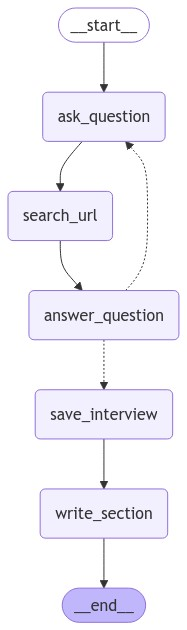

In [27]:
analysis_builder = StateGraph(SearchState)
analysis_builder.add_node("ask_question", generate_question)
analysis_builder.add_node("search_url", search_url)
analysis_builder.add_node("answer_question", generate_answer)
analysis_builder.add_node("save_interview", save_interview)
analysis_builder.add_node("write_section", write_section)

analysis_builder.add_edge(START, "ask_question")
analysis_builder.add_edge("ask_question", "search_url")
analysis_builder.add_edge("search_url", "answer_question")
analysis_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
analysis_builder.add_edge("save_interview", "write_section")
analysis_builder.add_edge("write_section", END)

memory = MemorySaver()
analysis_graph = analysis_builder.compile(checkpointer=memory).with_config(run_name="Conduct Analysis")

display(Image(analysis_graph.get_graph().draw_mermaid_png()))

In [28]:
# from IPython.display import Markdown
# messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
# thread = {"configurable": {"thread_id": "1"}}
# interview = analysis_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
# Markdown(interview['sections'][0])

In [29]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict, Optional

class AuditGraphState(TypedDict):
    url: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: Optional[str]
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

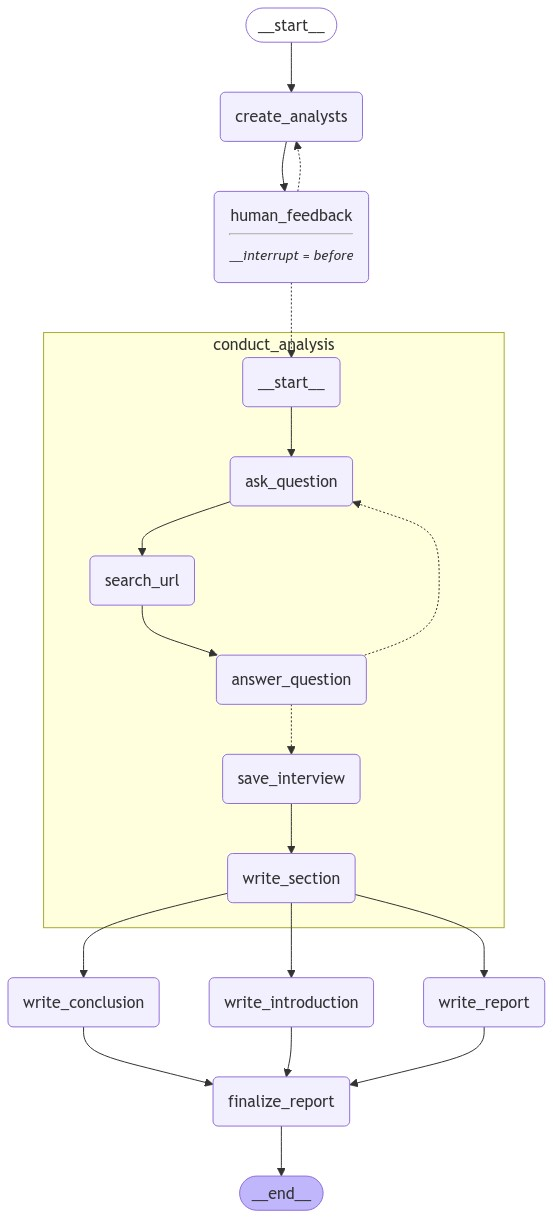

In [30]:
from langgraph.constants import Send

def initiate_all_analyst(state: AuditGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    else:
        url = state["url"]
        return [Send("conduct_analysis", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an audit on the NPO {url}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a member of Maggie’s marketing analysis team and your task  is to provides a comprehensive audit of 
online presence on the NPO's website.
    
You have a team of analysts. Each analyst has done three things: 

1. They analyzed how different key players in the nonprofit sector-perceive them buy their specific sub-topic.
2. They provided actionable recommendations based on their unique perspective, ensuring that all insights align with the NPO’s current strategic needs and objectives.
3. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative for each persona (audience) 

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: AuditGraphState):
    sections = state["sections"]
    url = state["url"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    system_message = report_writer_instructions.format(url=url, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on NPO with the url {url}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: AuditGraphState):
    sections = state["sections"]
    url = state["url"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    
    instructions = intro_conclusion_instructions.format(url=url, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: AuditGraphState):
    sections = state["sections"]
    url = state["url"]
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    instructions = intro_conclusion_instructions.format(url=url, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: AuditGraphState):
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    print("Final Report:", final_report)  # Debugging
    state["final_report"] = final_report  # Ensure state is updated
    return state


initial_state: AuditGraphState = {
    "url": url_input,
    "max_analysts": 3,
    "human_analyst_feedback": None,
    "analysts": [],
    "sections": [],
    "introduction": "",
    "content": "",
    "conclusion": "",
    "final_report": ""
}

builder = StateGraph(AuditGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_analysis", analysis_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_analyst, ["create_analysts", "conduct_analysis"])
builder.add_edge("conduct_analysis", "write_report")
builder.add_edge("conduct_analysis", "write_introduction")
builder.add_edge("conduct_analysis", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [31]:
thread = {"configurable": {"thread_id": "1"}}
for event in graph.stream(initial_state, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)


Name: Sarah Thompson
Affiliation: Volunteers
Role: Volunteer Engagement Analyst
Description: Sarah is responsible for analyzing the engagement and satisfaction of volunteers. She uses data to understand the motivations of volunteers, their experiences, and their retention rates. She also identifies opportunities to improve volunteer recruitment and engagement strategies.
--------------------------------------------------
Name: James Wilson
Affiliation: Foundations
Role: Grant Analyst
Description: James works closely with foundations to analyze the effectiveness of grant programs. He evaluates the impact of grants on the NPO's mission and identifies areas for improvement. He also provides insights into potential new funding opportunities.
--------------------------------------------------
Name: Emily Davis
Affiliation: Donors
Role: Donor Relations Analyst
Description: Emily's role is to analyze donor trends and behaviors. She uses this information to develop strategies to increase donor

In [32]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
print("Final Report Content:", report)

if report:
    display(Markdown(report))
else:
    print("No report generated.")

Final Report Content: 
No report generated.
